# XGBoost GPU Benchmarks

In this notebook, we benchmark the latest version of [XGBoost](https://github.com/dmlc/xgboost), the well-known Kaggle-winning gradient boosting algorithm, and in particular, the [XGBoost GPU plugin](https://github.com/dmlc/xgboost/blob/master/plugin/updater_gpu/README.md).
In addition, we showcase the H2O integration of XGBoost.

In [1]:
#!easy_install http://s3.amazonaws.com/h2o-deepwater/public/nightly/latest/xgboost-0.6-py2.7.egg ## for python 2
#!easy_install http://s3.amazonaws.com/h2o-deepwater/public/nightly/latest/xgboost-0.6-py3.5.egg ## for python 3
#!pip install http://s3.amazonaws.com/h2o-deepwater/public/nightly/latest/h2o-3.11.0-py2.py3-none-any.whl

In [2]:
%matplotlib inline
import xgboost as xgb
import pandas as pd
import numpy as np
import scipy as sp
import os
import time
from sklearn import metrics

In [3]:
if False:
    ## Kaggle dataset - download from 
    ## https://www.kaggle.com/c/santander-customer-satisfaction/data
    path = "/home/arno/kaggle/santander/data/train.csv"
    target = "TARGET"
    trainrows=60000
    drop_cols=["ID"]
    num_class = 2
    num_round = 200
    learn_rate = 0.02
    max_depth = 8

    ## Parse data into a Pandas Frame
    t_start = time.time()
    df = pd.read_csv(path)
    if drop_cols is not None:
        df = df.drop(drop_cols, axis=1)
    print("Time to parse by Pandas (sec): ", time.time() - t_start)

    df_target = df[target]
    df = df.drop(target, axis=1)
    cols = df.columns.values
    df.shape
else:
    ## Airline dataset
    ## https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/airlines_all.05p.csv"
    path = "/home/arno/h2o-3/bigdata/laptop/airlines_all.05p.csv"
    target = "IsDepDelayed"
    trainrows=3000000
    drop_cols=['ArrTime','DepTime','ActualElapsedTime','AirTime','ArrDelay',
               'DepDelay','TaxiIn', 'TaxiOut', 'Cancelled',
               'CancellationCode', 'Diverted', 'CarrierDelay', 
              'WeatherDelay', 'NASDelay', 'SecurityDelay', 'TailNum',
              'LateAircraftDelay', 'IsArrDelayed']
    header = None
    num_round = 100
    learn_rate = 0.02
    max_depth = 8
    num_class = 2

    ## Parse data into a Pandas Frame
    t_start = time.time()
    df = pd.read_csv(path,encoding= "ISO-8859-1")
    if drop_cols is not None:
        df = df.drop(drop_cols, axis=1)
    print("Time to parse by Pandas (sec): ", time.time() - t_start)

    df_target = df[target].replace(('YES', 'NO'), (1, 0))
    df = df.drop(target, axis=1)
    cols = df.columns.values
    df.shape

    from sklearn import preprocessing
    catcols = df.select_dtypes(include=['object'])
    cc = [x for x in list(catcols.columns)]
    for f in cc:
        df[f] = preprocessing.LabelEncoder().fit_transform(list(df[f].values))

/home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time to parse by Pandas (sec):  14.629498481750488


In [4]:
train = df.iloc[:trainrows,:]
test  = df.iloc[trainrows:,:]
train_target = df_target.iloc[:trainrows]
test_target  = df_target.iloc[trainrows:]

In [5]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 12 columns):
Year              int64
Month             int64
DayofMonth        int64
DayOfWeek         int64
CRSDepTime        int64
CRSArrTime        int64
UniqueCarrier     int64
FlightNum         int64
CRSElapsedTime    float64
Origin            int64
Dest              int64
Distance          float64
dtypes: float64(2), int64(10)
memory usage: 274.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834763 entries, 3000000 to 5834762
Data columns (total 12 columns):
Year              int64
Month             int64
DayofMonth        int64
DayOfWeek         int64
CRSDepTime        int64
CRSArrTime        int64
UniqueCarrier     int64
FlightNum         int64
CRSElapsedTime    float64
Origin            int64
Dest              int64
Distance          float64
dtypes: float64(2), int64(10)
memory usage: 259.5 MB
None


In [6]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                40
On-line CPU(s) list:   0-39
Thread(s) per core:    2
Core(s) per socket:    10
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz
Stepping:              1
CPU MHz:               1400.351
CPU max MHz:           3100.0000
CPU min MHz:           1200.0000
BogoMIPS:              4401.66
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              25600K
NUMA node0 CPU(s):     0-9,20-29
NUMA node1 CPU(s):     10-19,30-39
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopo

In [7]:
!cat /proc/meminfo | grep MemTotal

MemTotal:       264019784 kB


In [8]:
!nvidia-smi -L

GPU 0: GeForce GTX 1080 Ti (UUID: GPU-0eb406e1-1e7d-372f-c655-06fb94be3ea1)
GPU 1: GeForce GTX 1080 Ti (UUID: GPU-00bd4213-ce77-bfb8-012f-6600b2b105fa)


In [9]:
!nvidia-smi

Wed May 17 16:47:57 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 381.09                 Driver Version: 381.09                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 0000:02:00.0      On |                  N/A |
| 27%   44C    P5    26W / 250W |    913MiB / 11172MiB |     13%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 0000:81:00.0     Off |                  N/A |
| 23%   38C    P8    13W / 250W |      2MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [10]:
def runXGBoost(param):
    have_updater = "updater" in param.keys()
    label = "XGBoost " \
        + ("GPU hist" if have_updater and param["updater"]=="grow_gpu_hist" else "GPU exact" if have_updater and param["updater"]=="grow_gpu" else "CPU") \
        + " " + (param["tree_method"] if "updater" not in param.keys() else "")
    print(label)
    print("=====================")
    for k, v in param.items():
        print(k, v)
    print("=====================")
    
    t_start = time.time()
    dtrain = xgb.DMatrix(train.values, label = train_target.values, feature_names=[str(c) for c in cols])
    dtest  = xgb.DMatrix(test.values,  label = test_target.values,  feature_names=[str(c) for c in cols])
    tt = time.time() - t_start
    print("Time to create DMatrix (sec): ", tt)
    dmatrix_times.append(tt)
    
    t_start = time.time()
    bst = xgb.train(param, dtrain, num_round)
    tt = time.time() - t_start
    print("Time to train (sec): ", tt)
    train_times.append(tt)

    t_start = time.time()
    preds = bst.predict(dtest)
    tt = time.time() - t_start
    print("Time to predict (sec): ", tt)
    score_times.append(tt)

    labels = dtest.get_label()
    auc = metrics.roc_auc_score(labels, preds)
    print("AUC:", auc)
    valid_aucs.append(auc)
    plot_labels.append(label)
    
    fs = bst.get_fscore()
    
    # Optional: Uncomment to show variable importance
    #varimp = pd.DataFrame({'Importance': list(fs.values()), 'Feature': list(fs.keys())})
    #varimp.sort_values(by = 'Importance', inplace = True, ascending = False)
    #varimp.head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()

In [11]:
valid_aucs = []
dmatrix_times = []
train_times = []
score_times = []
plot_labels = []

In [12]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU exact
objective reg:logistic
max_depth 8
eta 0.02
tree_method exact
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  2.513124942779541
Time to train (sec):  207.36264038085938
Time to predict (sec):  1.0776019096374512
AUC: 0.630080186918


In [13]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"approx"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU approx
objective reg:logistic
max_depth 8
eta 0.02
tree_method approx
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  2.7356014251708984
Time to train (sec):  211.33267498016357
Time to predict (sec):  0.9265875816345215
AUC: 0.629924023466


In [14]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"hist"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU hist
objective reg:logistic
max_depth 8
eta 0.02
tree_method hist
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  2.587888717651367
Time to train (sec):  77.31922698020935
Time to predict (sec):  1.0576026439666748
AUC: 0.629687891783


In [15]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost GPU exact 
objective reg:logistic
max_depth 8
eta 0.02
tree_method exact
updater grow_gpu
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  2.4303436279296875
Time to train (sec):  58.58342146873474
Time to predict (sec):  1.0600135326385498
AUC: 0.626913681867


In [16]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu_hist"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost GPU hist 
objective reg:logistic
max_depth 8
eta 0.02
tree_method exact
updater grow_gpu_hist
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  2.3835229873657227
Time to train (sec):  9.591382026672363
Time to predict (sec):  1.0461761951446533
AUC: 0.627918966171


In [17]:
data = pd.DataFrame({'algorithm'  :plot_labels,
                     'dmatrix time':dmatrix_times,
                     'training time':train_times,
                     'scoring time':score_times,
                     'validation AUC' :valid_aucs}).sort_values(by="training time")
data

,algorithm,dmatrix time,scoring time,training time,validation AUC
4,XGBoost GPU hist,2.383523,1.046176,9.591382,0.627919
3,XGBoost GPU exact,2.430344,1.060014,58.583421,0.626914
2,XGBoost CPU hist,2.587889,1.057603,77.319227,0.629688
0,XGBoost CPU exact,2.513125,1.077602,207.362640,0.630080
1,XGBoost CPU approx,2.735601,0.926588,211.332675,0.629924


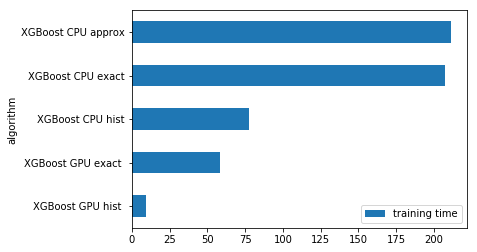

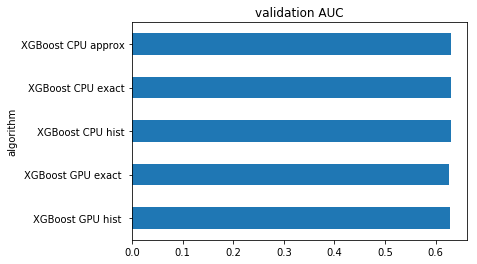

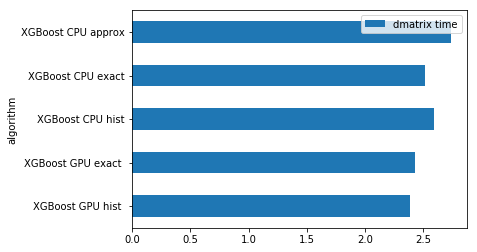

In [18]:
data.plot(label="training time",kind='barh',x='algorithm',y='training time')
data.plot(title="validation AUC",kind='barh',x='algorithm',y='validation AUC',legend=False)
data.plot(label="dmatrix time",kind='barh',x='algorithm',y='dmatrix time')

## Now call XGBoost from H2O

In [19]:
import h2o
from h2o.estimators import H2OXGBoostEstimator
h2o.init()

t_start = time.time()
df_hex = h2o.import_file(path)
print("Time to parse by H2O (sec): ", time.time() - t_start)

for c in drop_cols:
    df_hex = df_hex.drop(c, axis=1)

## Note: Frame contains categorical columns
## H2O internally handles them according to the 'categorical_encoding' parameter
trainhex = df_hex[:trainrows,:]
testhex  = df_hex[trainrows:,:]
trainhex[target] = (trainhex[target]).asfactor()
testhex[target] = (testhex[target]).asfactor()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /home/arno/.pyenv/versions/3.6.0/envs/h2oai/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpv379bi73
  JVM stdout: /tmp/tmpv379bi73/h2o_arno_started_from_python.out
  JVM stderr: /tmp/tmpv379bi73/h2o_arno_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster version:,3.11.0.248
H2O cluster version age:,7 hours and 48 minutes
H2O cluster name:,H2O_from_python_arno_4qls9y
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


Parse progress: |█████████████████████████████████████████████████████████| 100%
Time to parse by H2O (sec):  6.142284154891968


In [20]:
def runH2OXGBoost(param):
    label = "H2O XGBoost " \
    + ("GPU" if "backend" in param.keys() and "gpu"==param["backend"] else "CPU") \
    + (" " + param["tree_method"] if "tree_method" in param.keys() else "")
    print(label)
    print("=====================")
    for k, v in param.items():
        print(k, v)
    print("=====================")
        
    t_start = time.time()
    model = H2OXGBoostEstimator(**param)
    model.train(x = list(cols), y = target, training_frame = trainhex)
    tt = time.time() - t_start
    print("Time to train (sec): ", tt)
    h2o_train_times.append(tt)

    t_start = time.time()
    preds = model.predict(testhex)[:,2]
    tt = time.time() - t_start
    print("Time to predict (sec): ", tt)
    h2o_score_times.append(tt)

    preds = h2o.as_list(preds)
    labels = test_target.values
    auc = metrics.roc_auc_score(labels, preds)
    print("AUC:", auc)

    h2o_valid_aucs.append(auc)
    h2o_plot_labels.append(label)
    
    #pd.DataFrame(model.varimp(),columns=["Feature","","Importance",""]).head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()    

In [21]:
h2o_valid_aucs = []
h2o_train_times = []
h2o_score_times = []
h2o_plot_labels = []

In [22]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"exact"
}
runH2OXGBoost(param)

H2O XGBoost CPU exact
ntrees 100
max_depth 8
eta 0.02
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
score_tree_interval 100
backend cpu
tree_method exact
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  236.10045742988586
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  11.305573463439941
AUC: 0.630080186918


In [23]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"approx"
}
runH2OXGBoost(param)

H2O XGBoost CPU approx
ntrees 100
max_depth 8
eta 0.02
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
score_tree_interval 100
backend cpu
tree_method approx
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  233.8305742740631
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  11.045172214508057
AUC: 0.629924023466


In [24]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "eta":learn_rate
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"cpu"
    , "tree_method":"hist"
}
runH2OXGBoost(param)

H2O XGBoost CPU hist
ntrees 100
max_depth 8
eta 0.02
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
score_tree_interval 100
backend cpu
tree_method hist
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  97.46477270126343
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  12.549890756607056
AUC: 0.629687891783


In [25]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"gpu"
    , "tree_method":"exact"
}
runH2OXGBoost(param)

H2O XGBoost GPU exact
ntrees 100
max_depth 8
learn_rate 0.02
sample_rate 0.7
col_sample_rate_per_tree 0.9
min_rows 5
seed 12345
score_tree_interval 100
backend gpu
tree_method exact
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  89.5453429222107
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  12.487805366516113
AUC: 0.626913797683


In [26]:
param = {
    "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
    , "backend":"gpu"
    , "tree_method":"hist"
}
runH2OXGBoost(param)

H2O XGBoost GPU hist
ntrees 100
max_depth 8
learn_rate 0.02
sample_rate 0.7
col_sample_rate_per_tree 0.9
min_rows 5
seed 12345
score_tree_interval 100
backend gpu
tree_method hist
xgboost Model Build progress: |██████████████████████████████████████████████| 100%
Time to train (sec):  32.69223213195801
xgboost prediction progress: |████████████████████████████████████████████| 100%
Time to predict (sec):  11.002172470092773
AUC: 0.625015492318


## H2O GBM (CPU)

In [27]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
param = {
      "ntrees":num_round
    , "max_depth":max_depth
    , "learn_rate":learn_rate
    , "sample_rate":0.7
    , "col_sample_rate_per_tree":0.9
    , "min_rows":5
    , "seed":12345
    , "score_tree_interval":num_round
}

t_start = time.time()
model = H2OGradientBoostingEstimator(**param)
model.train(x = list(cols), y = target, training_frame = trainhex)
tt = time.time() - t_start
print("Time to train (sec): ", tt)
h2o_train_times.append(tt)

t_start = time.time()
preds = model.predict(testhex)[:,2]
tt = time.time() - t_start
print("Time to predict (sec): ", tt)
h2o_score_times.append(tt)

preds = h2o.as_list(preds)
labels = test_target.values
auc = metrics.roc_auc_score(labels, preds)
print("AUC:", auc)

h2o_valid_aucs.append(auc)
h2o_plot_labels.append("H2O GBM CPU")

# Show variable importance for the H2O GBM model
#pd.DataFrame(model.varimp(),columns=["Feature","","Importance",""]).head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Time to train (sec):  41.07345938682556
gbm prediction progress: |████████████████████████████████████████████████| 100%
Time to predict (sec):  7.937756299972534
AUC: 0.629372327273


In [28]:
data = pd.DataFrame({'algorithm'  :h2o_plot_labels,
                     'training time':h2o_train_times,
                     'scoring time':h2o_score_times,
                     'validation AUC' :h2o_valid_aucs}).sort_values(by="training time")
data

,algorithm,scoring time,training time,validation AUC
4,H2O XGBoost GPU hist,11.002172,32.692232,0.625015
5,H2O GBM CPU,7.937756,41.073459,0.629372
3,H2O XGBoost GPU exact,12.487805,89.545343,0.626914
2,H2O XGBoost CPU hist,12.549891,97.464773,0.629688
1,H2O XGBoost CPU approx,11.045172,233.830574,0.629924
0,H2O XGBoost CPU exact,11.305573,236.100457,0.630080


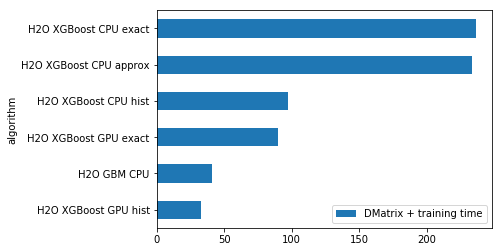

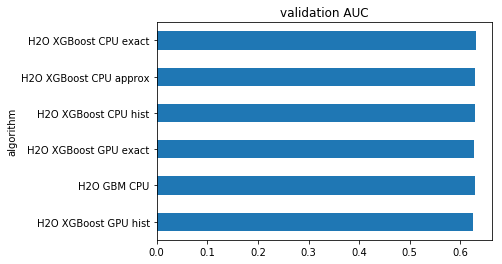

In [29]:
data.plot(label="DMatrix + training time",kind='barh',x='algorithm',y='training time')
data.plot(title="validation AUC",kind='barh',x='algorithm',y='validation AUC',legend=False)